In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import os.path
import jinja2

from IPython.display import HTML

/home/felipefg/.virtualenvs/analysis_py34/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
pd.set_option('max_colwidth',200)

In [3]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
sns.set_style("whitegrid")
sns.set_context("notebook")

In [5]:
# Data Input - all
#wordlist = pd.read_pickle('wordlist.p')
#models = pd.read_pickle('tuenti_models_40.p')
#docs_df = pd.read_pickle('tweets_tuenti_tokenized_all.p')
#model = models[40]
#topics = list(range(40))

# Murcia
wordlist = pd.read_pickle('wordlist.p')
models = pd.read_pickle('tuenti_models.p')
docs_df = pd.read_pickle('tweets_tuenti_tokenized.p')
model = models[10]
topics = list(range(10))

# Report Output
texdir = "report"
report_dir = "twitter_murcia"

basedir = os.path.join(texdir, report_dir)

In [6]:
wordlist_indices = dict(tuple(reversed(x)) for x in enumerate(wordlist))

doc_mat = np.zeros((docs_df.shape[0], len(wordlist)))

for idx_row, tokens in enumerate(docs_df['tokenized'].values):
    for token in tokens:
        token = token.lower()
        if token not in wordlist_indices:
            continue
            
        idx_token = wordlist_indices[token]
        doc_mat[idx_row, idx_token] = 1.0

In [7]:
doc_mat_norm = normalize(doc_mat)
S = np.dot(doc_mat_norm.T, doc_mat_norm)
D = np.power(np.sum(S, axis=1) + 1e-3, -0.5) * np.eye(S.shape[0])
Y = np.dot(D, doc_mat.T)

In [8]:
def get_results_df(docs, data, data_in):
    # Augment DF with topic number
    
    components = data['model'].components_
    
    clusters = np.argmax(data['V_T'], axis=1)
    clusters_series = pd.Series(clusters, index=docs.index, name="topic")

    vectors = components[clusters, :]
    
    # Manually compute cosine similarity, since it's not pairwise.
    cosine_num = (vectors * data_in).sum(axis=1)
    cosine_den = np.linalg.norm(vectors, axis=1) * np.linalg.norm(data_in, axis=1)
    cosine_sim = cosine_num / cosine_den
    
    similarity_series = pd.Series(cosine_sim, index=docs.index, name="similarity")
    
    # Compratio
    sorted_clusters = np.sort(data['V_T'], axis=1)
    compratio = sorted_clusters[:, -2] / sorted_clusters[:, -1]
    
    compratio_series = pd.Series(compratio, index=docs.index, name="compratio")
    
    return pd.concat([docs, clusters_series, similarity_series, compratio_series],
                     axis=1)

In [9]:
docs = get_results_df(docs_df, model, Y.T)

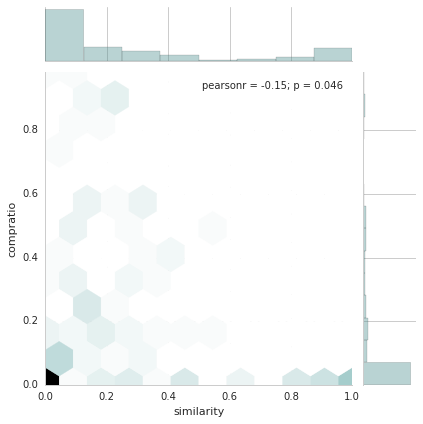

In [10]:
ax = sns.jointplot(x="similarity", y="compratio", data=docs, kind='hex', color='#529291')

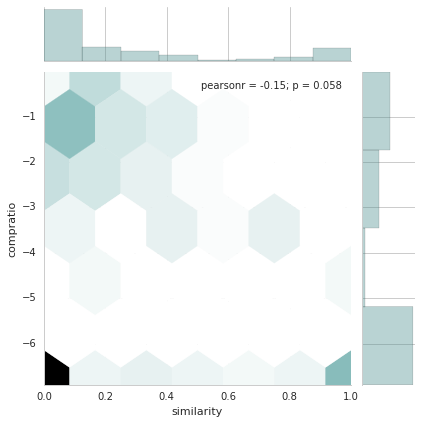

In [11]:
ax = sns.jointplot(x=docs["similarity"], y=np.log(docs["compratio"] + 1e-3), kind='hex', color='#529291')

# Plot de número de tweets por tempo

In [12]:
def plot_topic_over_time(docs, num_topic, freq="1d", ax=None):
    
    topic_docs = docs[docs['topic'] == num_topic]
    
    groups = topic_docs.groupby(pd.Grouper(key="created_at", freq=freq)).size()
    
    ax = groups.plot(ax=ax, marker="o", color='#529291')
    ax.set_xlabel("")
    return ax

In [13]:
for topic_num in topics:
    fig, ax = plt.subplots(figsize=(16, 3))
    plot_topic_over_time(docs, topic_num, ax=ax)
    
    filename = os.path.join(basedir, "report_images", "topic-%02d-timeseries.png" % topic_num)

    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close(fig)

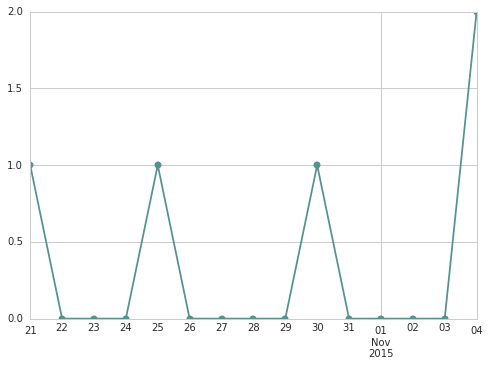

In [14]:
plot_topic_over_time(docs, 3)

# Tabela de tweets mais relevantes

In [15]:
def get_top_tweets(docs, num_topic, sort_col="similarity", sort_ascending=False, head=5):
       
    topic_docs = docs[docs['topic'] == num_topic].copy()
    
    topic_docs = topic_docs.groupby("text", sort=False).apply(
        lambda x: pd.Series(
            {
                "created_at": x["created_at"].min(),
                "count": x.shape[0],
                "relevance": x[sort_col].iloc[0],
            }
        )
    ).reset_index()

    topic_docs.sort_values(by=["relevance", "created_at"], ascending=[sort_ascending, True], inplace=True)
    
    topic_docs = topic_docs[["created_at", "count", "text", "relevance"]]
    topic_docs.columns = ["Date", "Count", "Text", "Relevance"]

    return topic_docs.head(head)

In [16]:
HTML(get_top_tweets(docs, 1, head=10).to_html(index=True))

,Date,Count,Text,Relevance
0,2015-11-03 17:53:47,9,"RT @VictorEmeceh: Tuenti empezó cambiando un poco, y mira como acabo. @Twitter esperemos que no hayas contratado al mismo diseñador, os lo …",0.989747
5,2015-11-01 15:33:19,1,Me acabo de meter a Tuenti vale y no me acuerdo de como se usaba eso 😂😂,0.189389
2,2015-10-28 13:00:45,1,RT @MrsPizzzza: Mi whatsapp ahora mismo está más muerto que el tuenti de todos nosotros,0.178505
6,2015-11-02 23:18:04,1,@jaime_salinas92 Tuenti está muerto,0.038349
1,2015-10-26 20:34:08,1,Reacción a mi Tuenti | Diego Breathe https://t.co/zMmkogZ6WA vía @YouTube,0.015766
4,2015-10-26 20:48:00,1,RT @DeseoLiterario: Reacción a mi Tuenti | Diego Breathe https://t.co/zMmkogZ6WA vía @YouTube,0.015766
3,2015-11-05 21:35:41,1,"Pepeenergy de Pepephone y Móvil sin Móvil de .Tuenti, innovaciones 2015 #PremiosADSLZone https://t.co/TUSrOtMGK1 via @adslzone",0.004150


In [17]:
#for topic_num in topics:
#    
#    top_tweets = get_top_tweets(docs_40, topic_num, head=10)
#    top_tweets_latex = top_tweets.to_latex(index=False)
#    
#    filename = os.path.join(basedir, "tables", "table-%02d-tweets.tex" % topic_num)
#    
#    with open(filename, "w") as fout:
#        fout.write(top_tweets_latex)

# Tabela de termos mais relevantes

In [18]:
def get_terms(data, wordlist, num_topic, n_words=10):
    
    components = data['model'].components_
    
    words_idxs = np.argsort(-1*components, axis=1)[:,:n_words]
    words_coef = -1 * np.sort(-1*components, axis=1)[:,:n_words]
    
    np_wordlist = np.array(wordlist)
    
    words = np_wordlist[words_idxs]
    
    return pd.Series(words_coef[num_topic, :], index=words[num_topic, :])


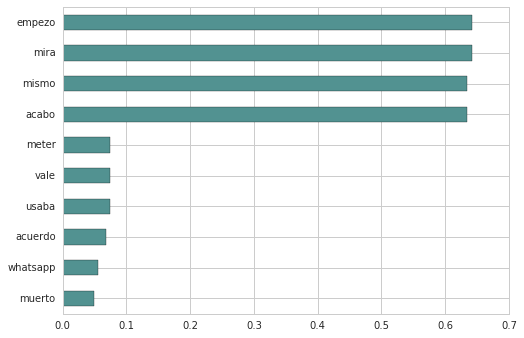

In [19]:
get_terms(model, wordlist, 1).sort_values(ascending=True).plot(kind="barh", color='#529291')

In [20]:
for topic_num in topics:

    fig, ax = plt.subplots(figsize=(8, 5))

    top_terms = get_terms(model, wordlist, topic_num).sort_values(ascending=True)
    top_terms.plot(kind="barh", color='#529291', ax=ax)
    
    
    filename = os.path.join(basedir, "report_images", "topic-%02d-terms.png" % topic_num)
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close(fig)

# Wordcloud

In [21]:
from wordcloud import WordCloud

def plot_wordcloud(words, ax=None, **kwargs):
    
    default_kwargs = {
        "font_path": "impact.ttf",
        "background_color": "white",
        "max_font_size": 70,
        "prefer_horizontal": 1.0,
        "width": 700,
        "height": 300,
    }
    
    default_kwargs.update(kwargs)
    wordcloud = WordCloud(**default_kwargs)
    generated_wordcloud = wordcloud.generate_from_frequencies(words)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.set_aspect('equal')
    ax.imshow(generated_wordcloud)
    ax.axis("off")
    return generated_wordcloud


def plot_topic_wordclouds(data, wordlist, idx_topic, ax=None):
    
    components = data['model'].components_
    sorted_components = np.sort(-1*components)*-1
    word_idxs = np.argsort(-1*components, axis=1)[:,:50]
    words = np.array(wordlist)[word_idxs]
    weights = sorted_components[:,:50]
    
    # Find minimum weight that is still greater than 0.01
    all_weights = weights.reshape((-1,))
    all_weights.sort()
    min_weight = all_weights[all_weights >= 0.01][0]
    weights = weights / min_weight
    weights = weights.round().astype('int')
    
        
    topic_terms = words[idx_topic, :].tolist()
    topic_weights = weights[idx_topic, :].tolist()
    topic_words = list(zip(topic_terms, topic_weights))
    topic_words.sort(key=lambda x:x[1], reverse=True)

    return plot_wordcloud(topic_words, ax=ax)

/home/felipefg/.virtualenvs/analysis_py34/lib/python3.4/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


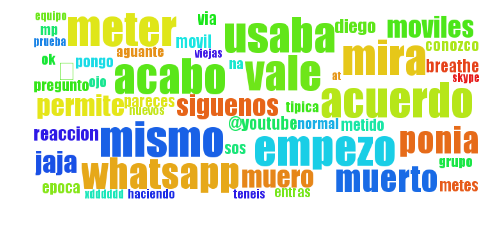

In [22]:
plot_topic_wordclouds(model, wordlist, 1)

In [23]:
for topic_num in topics:

    fig, ax = plt.subplots(figsize=(8, 5))

    plot_topic_wordclouds(model, wordlist, topic_num, ax=ax)

    filename = os.path.join(basedir, "report_images", "topic-%02d-wordcloud.png" % topic_num)
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close(fig)

/home/felipefg/.virtualenvs/analysis_py34/lib/python3.4/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


# Relatório .tex

In [24]:
LATEX_REPLACES = [
    ('\\', '\\textbackslash{}'),  # escape backslashes first
    ('_', '\\_'),
    ('%', '\\%'),
    ('$', '\\$'),
    ('#', '\\#'),
    ('{', '\\{'),
    ('}', '\\}'),
    ('~', '\\textasciitilde{}'),
    ('^', '\\textasciicircum{}'),
    ('&', '\\&'),
]


def escape_tex(text):
    """Latex escape function, inspired by Pandas' own escaping."""

    for replace in LATEX_REPLACES:
        text = text.replace(*replace)

    return text if text else '{}'


def format_latex_tabular_cell(text):
    """Quick trick for breaking line inside cells."""
    text = escape_tex(text)
    lines = text.split('\n')
    if len(lines) == 1:
        return lines[0]
    
    return "\\begin{tabular}[c]{@{}l@{}}%s\\end{tabular}" % " \\\\ ".join(lines)

In [25]:
docs_latex = docs.copy()
docs_latex['text'] = docs_latex['text'].apply(format_latex_tabular_cell)
top_tweets = dict((topic_num, get_top_tweets(docs_latex, topic_num, head=20)) for topic_num in topics)

In [26]:
report_template = jinja2.Template("""{% for topic_num in topics -%}
\\clearpage

\\section{Topic {{ "%02d"|format(topic_num) }}}

\\begin{figure}[htbp!]
    \\centering
    \\begin{subfigure}[b]{0.49\\textwidth}
        \\includegraphics[width=\\textwidth]{{ '{'}}{{ reportdir }}/report_images/topic-{{ "%02d"|format(topic_num) }}-wordcloud.jpg}
    \\end{subfigure}
    \\begin{subfigure}[b]{0.49\\textwidth}
        \\includegraphics[width=\\textwidth]{{ '{'}}{{ reportdir }}/report_images/topic-{{ "%02d"|format(topic_num) }}-terms.jpg}
    \\end{subfigure}
\\end{figure}

\\begin{figure}[htbp!]
    \\centering
    \\includegraphics[width=\\textwidth]{{ '{'}}{{ reportdir }}/report_images/topic-{{ "%02d"|format(topic_num) }}-timeseries.jpg}
\\end{figure}

\\rowcolors{2}{gray!25}{white}
\\begin{longtable}{p{12.5cm}rr}
\\toprule
Text & Count & Rel \\\\
\\midrule
\\endhead
\\midrule
\\multicolumn{3}{r}{{ '{{' }}Continued on next page{{ '}}' }} \\\\
\\midrule
\\endfoot

\\bottomrule
\\endlastfoot
{% for row_id, row in top_tweets[topic_num].iterrows() -%}
{{ row.Text }} & {{ row.Count }} & {{ "%4.2f"|format(row.Relevance) }} \\\\
{% endfor %}
\\end{longtable}
{% endfor %}
""")

In [27]:
rendered = report_template.render(
    topics=topics,
    top_tweets=top_tweets,
    reportdir=report_dir
)

In [28]:
filename = os.path.join(basedir, "topics_report.tex")

with open(filename, "w", encoding="utf-8") as fout:
    fout.write(rendered)
    fout.write('\n')

# Converte imagens para JPG

In [29]:
%%bash -s "$basedir"

for png_file in $1/report_images/*.png; do 
    echo $png_file
    convert -quality 65 $png_file ${png_file/.png/.jpg}
done

report/twitter_murcia/report_images/topic-00-terms.png
report/twitter_murcia/report_images/topic-00-timeseries.png
report/twitter_murcia/report_images/topic-00-wordcloud.png
report/twitter_murcia/report_images/topic-01-terms.png
report/twitter_murcia/report_images/topic-01-timeseries.png
report/twitter_murcia/report_images/topic-01-wordcloud.png
report/twitter_murcia/report_images/topic-02-terms.png
report/twitter_murcia/report_images/topic-02-timeseries.png
report/twitter_murcia/report_images/topic-02-wordcloud.png
report/twitter_murcia/report_images/topic-03-terms.png
report/twitter_murcia/report_images/topic-03-timeseries.png
report/twitter_murcia/report_images/topic-03-wordcloud.png
report/twitter_murcia/report_images/topic-04-terms.png
report/twitter_murcia/report_images/topic-04-timeseries.png
report/twitter_murcia/report_images/topic-04-wordcloud.png
report/twitter_murcia/report_images/topic-05-terms.png
report/twitter_murcia/report_images/topic-05-timeseries.png
report/twitter_